---
# **Task 4: Model Comparison & Interpretability**

**Objectives:**
- Compare all models
- Error analysis
- SHAP values for feature importance
- Deployment recommendations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import joblib

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

c:\Users\zaber\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading Model and Data
best_gb = joblib.load("../data/best_gb_model.pkl")

# Loading preprocessed data
X_train = np.load("../data/X_train_processed.npy")
X_test = np.load("../data/X_test_processed.npy")
y_test = np.load("../data/y_test.npy")

# Loading feature names
feature_names = np.load(
    "../data/feature_names.npy",
    allow_pickle=True
)

print("Model and data loaded successfully:")
print("-" * 30)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"Number of feature names: {len(feature_names)}")

Model and data loaded successfully:
------------------------------
X_train shape: (5625, 45)
X_test shape:  (1407, 45)
Number of feature names: 45


In [3]:
# Sanity Checks
print("Sanity Check: Feature Alignment")
print("-" * 30)
print(f"X_test shape: {X_test.shape}")
print(f"Number of feature names: {len(feature_names)}")

assert X_test.shape[1] == len(feature_names), \
    "Mismatch between feature matrix and feature names!"

Sanity Check: Feature Alignment
------------------------------
X_test shape: (1407, 45)
Number of feature names: 45


In [4]:
# Initializing SHAP Explainer
explainer = shap.TreeExplainer(best_gb)

In [5]:
# Computing SHAP Values
shap_values = explainer.shap_values(X_test)

# Use SHAP values for the positive class (Churn = 1)
shap_values_churn = shap_values[1]

print("SHAP values computed successfully:")
print("-" * 35)
print(f"SHAP values shape (churn class): {shap_values_churn.shape}")

SHAP values computed successfully:
-----------------------------------
SHAP values shape (churn class): (45,)


In [6]:
# Compute SHAP values (modern API)
shap_values = explainer(X_test)

print("SHAP values array shape:", shap_values.values.shape)
print("X_test shape:", X_test.shape)


SHAP values array shape: (1407, 45)
X_test shape: (1407, 45)


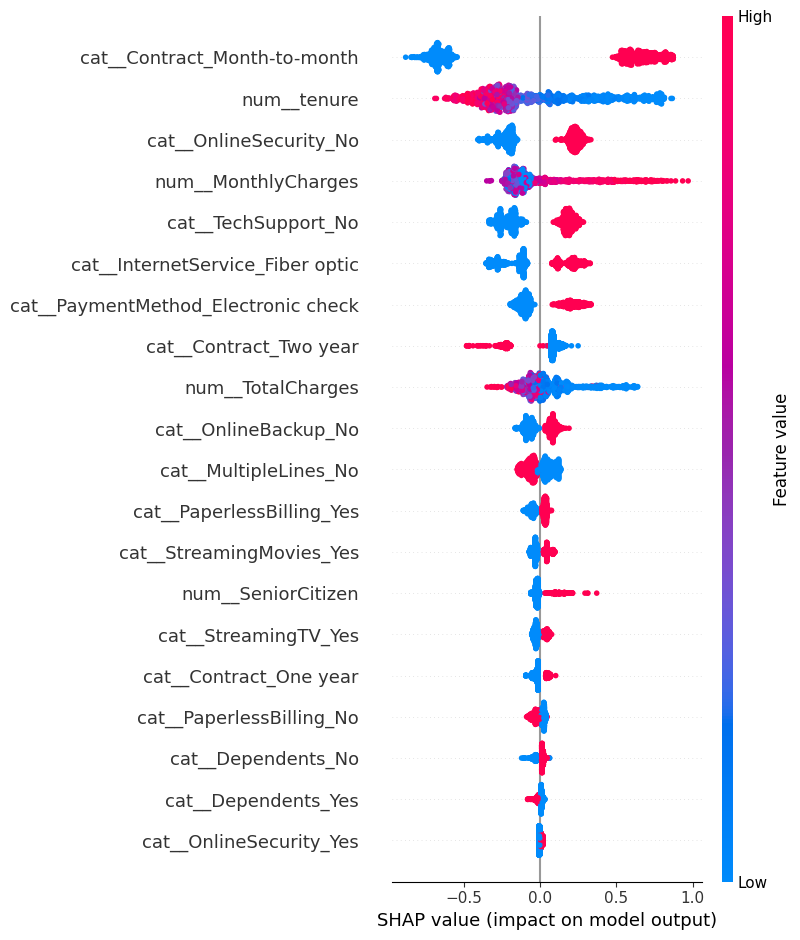

In [7]:
# Global Feature Importance
shap.summary_plot(
    shap_values.values,
    X_test,
    feature_names=feature_names,
    show=True
)


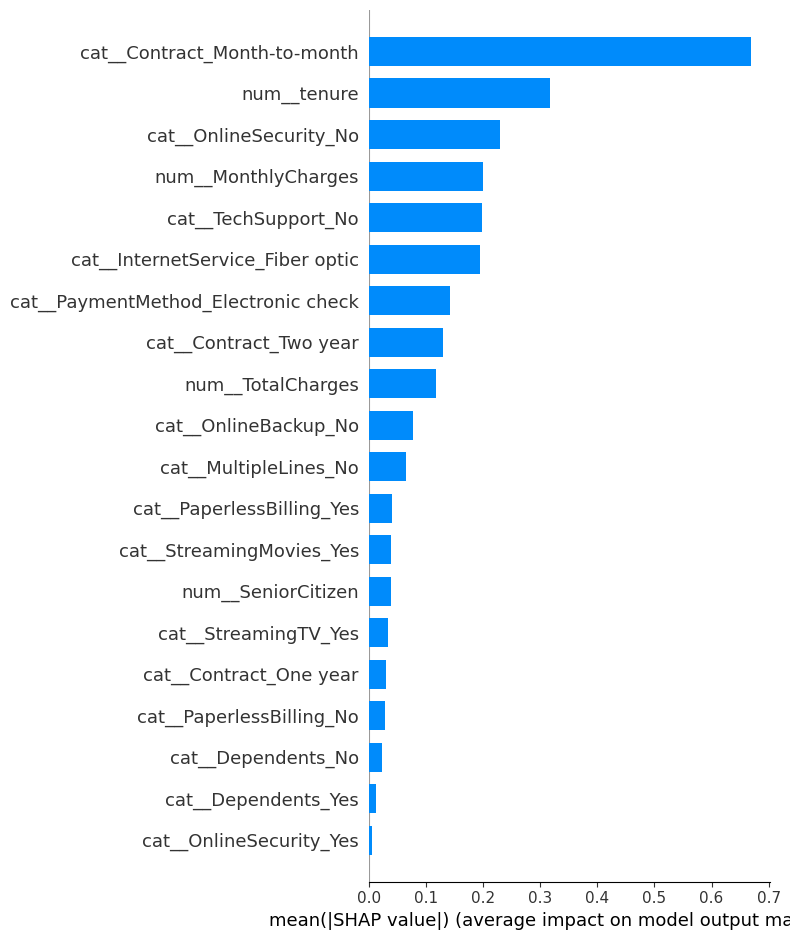

In [8]:
# Global Feature Importance (Bar Plot)
shap.summary_plot(
    shap_values.values,
    X_test,
    feature_names=feature_names,
    plot_type="bar",
    show=True
)


In [9]:
# Identifying Misclassified Examples
y_pred = best_gb.predict(X_test)
misclassified_idx = np.where(y_pred != y_test)[0]

print("Error Analysis:")
print("-" * 20)
print(f"Total test samples: {len(y_test)}")
print(f"Number of misclassified samples: {len(misclassified_idx)}")
print(f"First 5 misclassified indices: {misclassified_idx[:5]}")

Error Analysis:
--------------------
Total test samples: 1407
Number of misclassified samples: 292
First 5 misclassified indices: [ 1  3  5 10 12]


In [10]:
# Local Explanation for a Misclassified Sample
i = misclassified_idx[0]

shap.initjs()

shap.force_plot(
    shap_values.base_values[i],
    shap_values.values[i],
    X_test[i],
    feature_names=feature_names
)

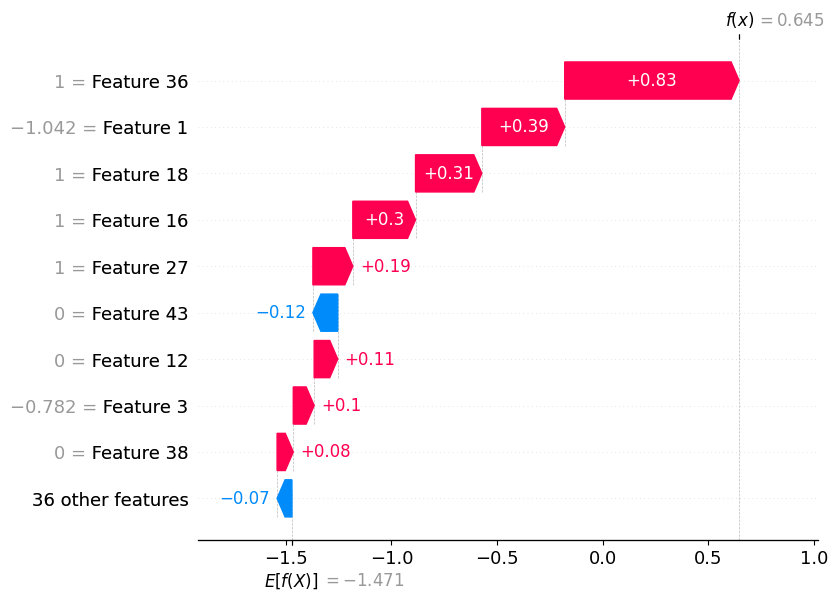

In [11]:
# Local Explanation using Waterfall Plot
i = misclassified_idx[0]  # index of a misclassified test sample

shap.plots.waterfall(shap_values[i])

In [12]:
# Consistency Checking with EDA (Top SHAP Features)
top_features = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_shap": np.abs(shap_values.values).mean(axis=0)
}).sort_values("mean_abs_shap", ascending=False)

print("Top 10 Features by Mean |SHAP| Value:")
print("-" * 45)
print(top_features.head(10))

print("\nSHAP analysis completed successfully.")

Top 10 Features by Mean |SHAP| Value:
---------------------------------------------
                                feature  mean_abs_shap
36         cat__Contract_Month-to-month       0.668945
1                           num__tenure       0.317654
18               cat__OnlineSecurity_No       0.229471
2                   num__MonthlyCharges       0.199725
27                  cat__TechSupport_No       0.197806
16     cat__InternetService_Fiber optic       0.194172
43  cat__PaymentMethod_Electronic check       0.142681
38               cat__Contract_Two year       0.129563
3                     num__TotalCharges       0.117430
21                 cat__OnlineBackup_No       0.078427

SHAP analysis completed successfully.


### SHAP Interpretability Summary

- SHAP analysis was applied to the best-performing Gradient Boosting model.
- Global explanations show that tenure, contract type, monthly charges, and internet service are the most influential features.
- Local explanations provide insight into individual customer predictions, increasing model transparency.
- SHAP results are consistent with EDA findings, validating model behavior.
